# CS4035 - Cyber Data Analytics
## Lab 2 

### Submit on brightspace (zip file with the name Group_xx.zip)
(i) This jupyter file completed with code, plots, figures and report for each question. Additional plots and figures can be created for explanation before the end of each main question. Lab 2 contains 7 main questions, including the bonus. Write the code or explanation below each sub question. For the explantions, include what you would normally include in the report for this lab assignment, for example data pre-processing, hypothesis tested, approach, results, etc.
(ii) A PDF or a Word report for the assignment. Create a report from the plots, figures, tables and the write-up that you provide in this jupyter file. The report will be used as a proof for page limit. 
(iii) The libraries needed to run this file. 

Your peers should be able to use the readme section for instructions and be able to run this file. 

Dataset here : https://www.batadal.net/data.html You will need Training Dataset 1, Training Dataset 1 and Test Dataset.

## Group Number : 15

## Student 1 
### Name : Nikhil Saldanha
### ID : 4998707

## Student 2
### Name : Sharwin Bobde
### ID : 5011639

## Readme - Provide instructions - libraries used, location of the data file, etc. Keep it short. Remember your peers will not debug your code and should be able to reproduce the exact output you provide.

### Instructions for setting up
- Create a folder for the data called `data/`.
- Download the data into `data/` from [here](https://www.batadal.net/data.html).
- Setup virtualenv: `virtualenv -p python3 env`
- Enter virtualenv: `source env/bin/activate`
- Start Jupyter Server: `jupyter notebook .`

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft

In [18]:
from sklearn.ensemble import RandomForestRegressor

In [8]:
from tqdm import tqdm

In [45]:
from sklearn.neighbors import LocalOutlierFactor

In [46]:
from sklearn.metrics import confusion_matrix

## 1. Familiarization task – 1 A4

### 1a. Plot visualizations 

In [2]:
data_1 = pd.read_csv("data/BATADAL_dataset03.csv")
# account for space after the comma in the delimiter
data_2 = pd.read_csv("data/BATADAL_dataset04.csv", delimiter=r",\s{0,1}")
test_data = pd.read_csv("data/BATADAL_test_dataset.csv")

# convert DATETIME column to datetime
data_1["DATETIME"] = pd.to_datetime(data_1.DATETIME)
data_2["DATETIME"] = pd.to_datetime(data_2.DATETIME)
test_data["DATETIME"] = pd.to_datetime(test_data.DATETIME)

<ipython-input-2-356782e260f6>:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  data_2 = pd.read_csv("data/BATADAL_dataset04.csv", delimiter=r",\s{0,1}")


In [3]:
signals = ['L_T1', 'L_T2', 'L_T3', 'L_T4', 'L_T5', 'L_T6', 'L_T7',
       'F_PU1', 'S_PU1', 'F_PU2', 'S_PU2', 'F_PU3', 'S_PU3', 'F_PU4', 'S_PU4',
       'F_PU5', 'S_PU5', 'F_PU6', 'S_PU6', 'F_PU7', 'S_PU7', 'F_PU8', 'S_PU8',
       'F_PU9', 'S_PU9', 'F_PU10', 'S_PU10', 'F_PU11', 'S_PU11', 'F_V2',
       'S_V2', 'P_J280', 'P_J269', 'P_J300', 'P_J256', 'P_J289', 'P_J415',
       'P_J302', 'P_J306', 'P_J307', 'P_J317', 'P_J14', 'P_J422']

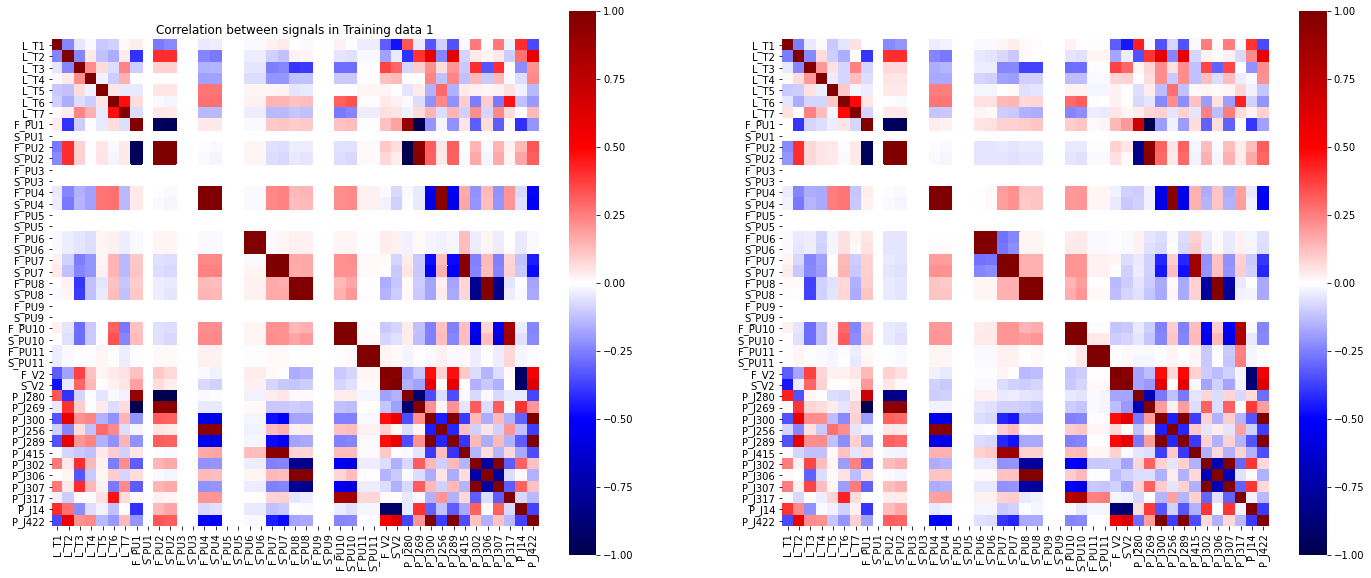

In [4]:
f, (ax1, ax2) = plt.subplots(1,2,figsize =(24, 10))

sns.heatmap(data_1[signals].corr(), square=True, vmin=-1, vmax=1, ax=ax1, cmap='seismic')
ax1.set_title("Correlation between signals in Training data 1")
sns.heatmap(data_2[signals].corr(), square=True, vmin=-1, vmax=1, ax=ax2, cmap='seismic')
ax1.set_title("Correlation between signals in Training data 1")
plt.show()

100%|██████████| 43/43 [00:00<00:00, 478.44it/s]


Rendering... Please wait


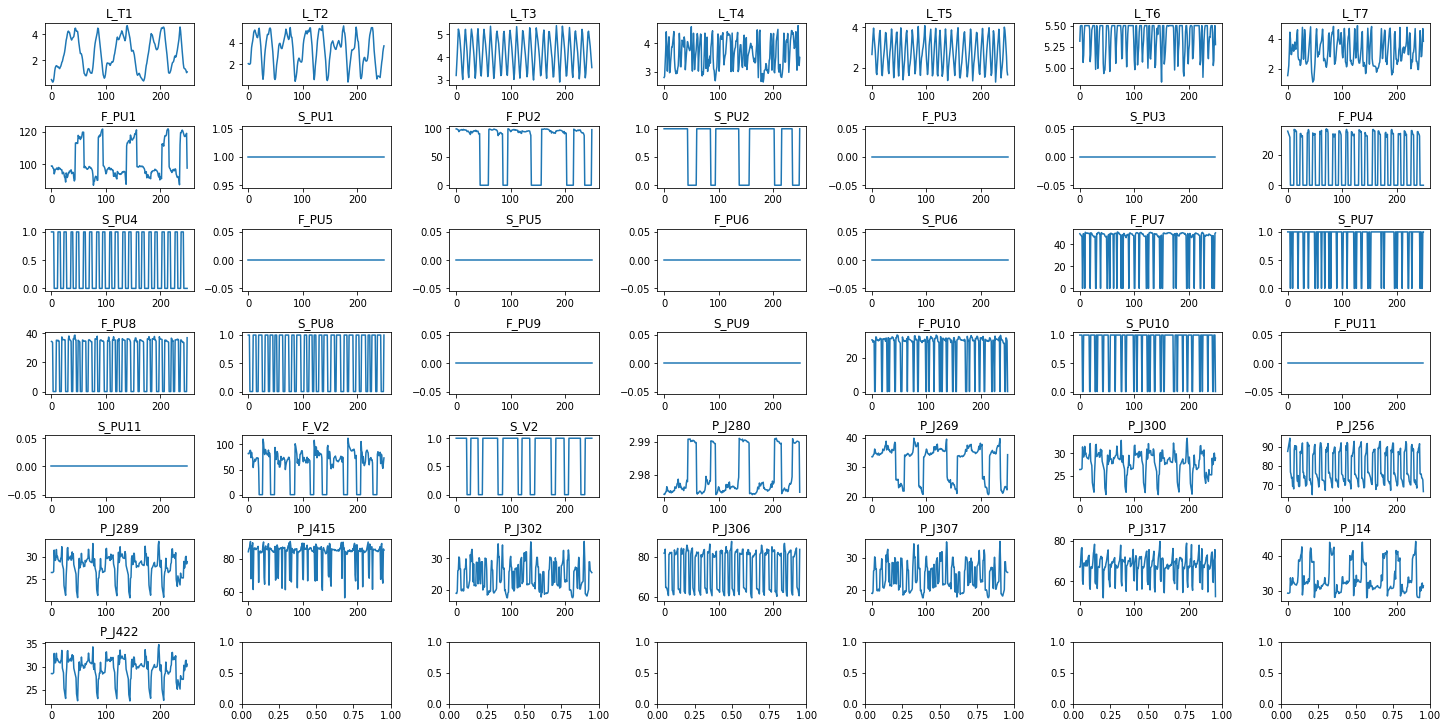

100%|██████████| 43/43 [00:00<00:00, 107.92it/s]


Rendering... Please wait


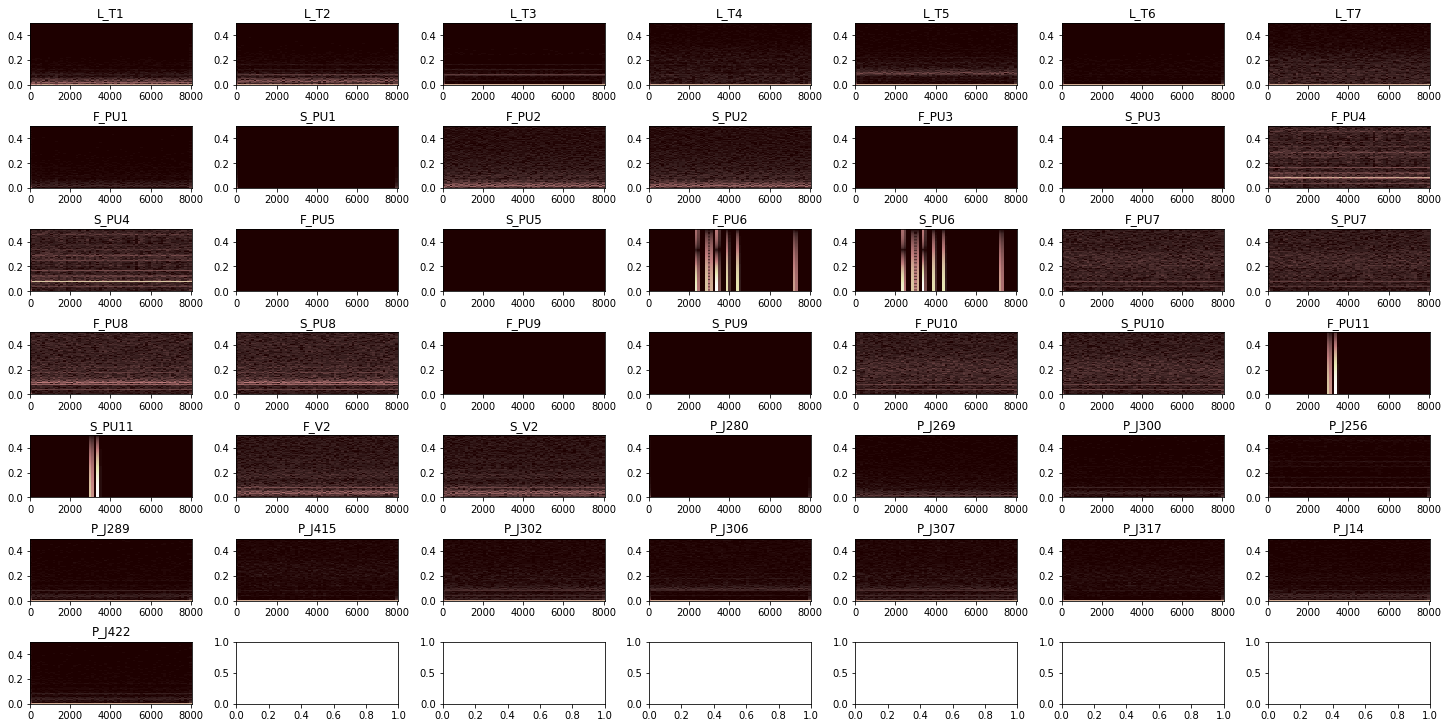

In [10]:
fig, axs = plt.subplots(7,7, constrained_layout=True)
fig.set_size_inches((20,10))
for i in tqdm(range(len(signals))):
       a,b = (int(i/7), i%7)
       axs[a,b].plot(range(250), data_1[signals[i]][0:250])
       axs[a,b].set_title(signals[i])
print('Rendering... Please wait')
plt.show()

In [ ]:
fig, axs = plt.subplots(7,7, constrained_layout=True)
fig.set_size_inches((20,10))
for i in tqdm(range(len(signals))):
       a,b = (int(i/7), i%7)
       f, t, Zxx = stft(data_1[signals[i]][0:8000], nperseg=256)
       axs[a,b].pcolormesh(t, f, np.abs(Zxx), cmap='pink')
       axs[a,b].set_title(signals[i])
print('Rendering... Please wait')
plt.show()

In [11]:
def slide_dataset(data: np.array, window_size: int, stride: int = 1) -> np.array:
    """
    Takes Nx1 dimensional data in form of a numpy array and
    creates data by sampling in a window_size W and stride S.
    Returns a (N - W)/S x W dimensional data
    """
    N = data.shape[0]
    num_samples = int(N - window_size / stride)
    
    # new empty numpy array to store the data with sliding window
    slid_dataset = np.empty((num_samples, window_size))

    # loop over the data and sample according
    # to window size and stride
    for i in range(window_size, N, stride):
        slid_dataset[i-window_size] = data[i-window_size:i]
    
    return slid_dataset

In [38]:
def plot_prediction(y_true, y_pred, ax, title, num_points=1000):
    ax.plot([i for i in range(num_points)], y_true[:num_points], label="actual")
    ax.plot([i for i in range(num_points)], y_pred[:num_points], label="predicted")
    ax.legend()
    ax.set_title(title)

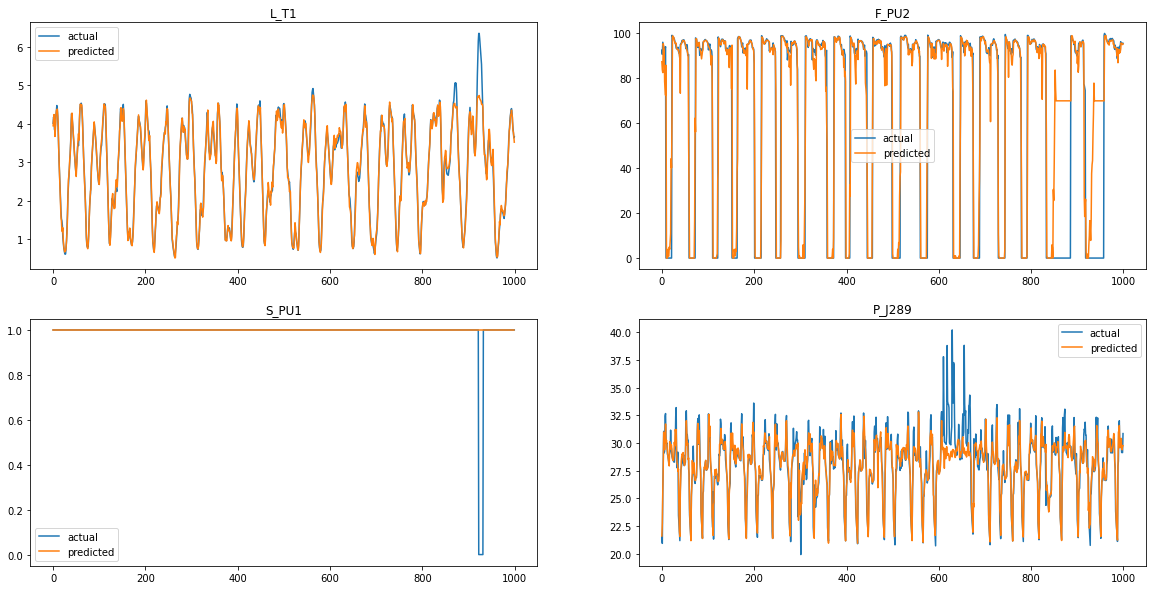

In [41]:
# decide window size
window_size = 24

# decide signals
signals = ["L_T1", "F_PU2", "S_PU1", "P_J289"]

fig, axs = plt.subplots(2, 2)
fig.set_size_inches((20,10))
for i, signal in enumerate(signals):
    # create sliding window dataset
    slid_train = slide_dataset(data_1[signal].to_numpy(), window_size)
    slid_test = slide_dataset(test_data[signal].to_numpy(), window_size)

    # create train, test and validation sets
    X_train = slid_train[:,:window_size-1]
    y_train = slid_train[:,window_size-1]

    X_test = slid_test[:,:window_size-1]
    y_test = slid_test[:,window_size-1]
    
    # create a random forest regression model
    rf_clf = RandomForestRegressor()
    
    # fit and predict
    rf_clf.fit(X_train, y_train)
    
    y_pred_test = rf_clf.predict(X_test)
    plot_prediction(y_test, y_pred_test, axs[int(i/2), i%2], title=signal)
plt.show()

### 1b. Answers to the three questions

**1. What types of signals are there?**

In the dataset, the signals prefixed with "S" are state variables which are discrete, the signals prefixed with "L" denote the water levels, "F" signals are for flow and "P" signals are for inlet and outlet pressure. We see that each of these signals have their own characteristic shape.

**2. Are the signals correlated? Do they show cyclic behavior?**

TODO: sharwin

**3. Is predicting the next value in a series easy or hard? Use any method from class**

We make an attempt at predicting the next value in the series of the signals L_T1, F_PU2, S_PU1, P_J289 using the sliding window technique. According to our observations, the model can reasonable predict the next value of the signal when there are no sudden and large changes in it. In our visualizations above, we can see that when S_PU1 drops to 0 and then back to 1 in a short interval, the model is not able to predict this. We can see similar patterns in other signals as well. Hence, we would say that whether it is hard or easy depends on the characteristic of the signal itself.

## 2. LOF task – 1/2 A4 – Nikhil Saldanha

### 2a. Plot LOF scores

In [98]:
# remove label and datetime column
X_train = data_1[set(data_1.columns)-{"ATT_FLAG", "DATETIME"}].to_numpy()
y_train = np.zeros((X_train.shape[0], ))

X_valid = data_2[set(data_2.columns)-{"ATT_FLAG", "DATETIME"}].to_numpy()
y_valid = data_2["ATT_FLAG"].to_numpy()
# convert to 1s for attack and 0s for normal
y_valid = y_valid == 1

lofs = []
nns = [i for i in range(1, 120)]
tps = []
fns = []
for nn in nns:
    clf = LocalOutlierFactor(n_neighbors=nn, algorithm='kd_tree', leaf_size=100,
                             metric='minkowski', p=1, contamination="auto", novelty=True, n_jobs=-1)
    clf.fit(X_train)
    lof = clf.negative_outlier_factor_
    lofs.append(lof)

    y_pred = clf.predict(X_valid)
    y_pred = y_pred == -1
    y_pred = y_pred.astype(float)

    tn, fp, fn, tp = confusion_matrix(y_valid, y_pred).ravel()
    tps.append(tp)
    fns.append(fn)

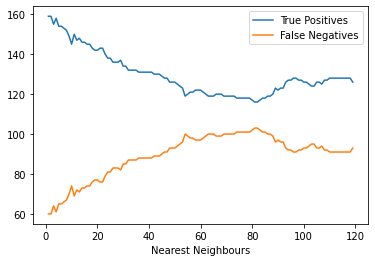

In [99]:
plot_df = pd.DataFrame({"True Positives": tps, "False Negatives": fns, "Nearest Neighbours": nns})
sns.lineplot(x="Nearest Neighbours", y=tps, data=plot_df, legend='brief', label="True Positives")
sns.lineplot(x="Nearest Neighbours", y=fns, data=plot_df, legend='brief', label="False Negatives")

We choose a nearest neighbour value of 95 since at that value, the number of TPs and FNs are stable and do not change with increase nearest neighbour values. At this value, we see the distribution of LOF scores below:

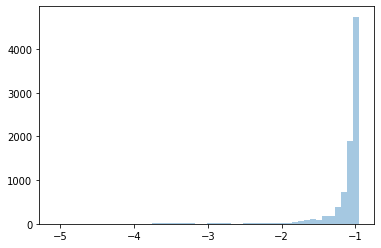

In [102]:
sns.distplot(lofs[94], kde=False)
plt.show()

### 2b. Analysis and answers to the questions

**1. Do you see large abnormalities in the training data? Can you explain why these occur?**
Yes, we can see the large abnormalities in the training data through the LOF scores above. The model takes -1.5 as the threshold below which the samples are classified as outliers. These are possibly the datapoints that have sudden changes in their values as we saw in the familiarization task.


**2. It is best to remove such abnormalities from the training data since you only want to model normal behavior?**
We would say that it is not a good idea to remove these from the training data since they are already part of normal behaviour and we should model these kinds of patterns as well.


**3. Describe the kind of anomalies you can detect using LOF**

With LOF you can detect point anomalies since it measures the local deviation of density of a given sample with respect to its neighbors. It is local in that the anomaly score depends on how isolated the object is with respect to the surrounding neighborhood. A point anomaly is defined as: A single instance of data that is anomalous since it deviates largely from the rest of the data points.

## 3. PCA task – 1/2 A4 – Sharwin Bobde

### 3a. Plot PCA residuals

### 3b. Analysis and answers to the questions

## 4. ARMA task – 1/2 A4 - Nikhil Saldanha

### 4a. Print relevant plots and/or metrics to determine the parameters.

### 4b. Plots to study the detected anomalies

### 4c. Analysis and answers to the questions

## 5. N-gram task – 1/2 A4 - Sharwin Bobde

### 5a. Visualise discretization

### 5b. Analysis and answers to the questions. Also provide relevant plots.

## 6.Comparision task 1 A4

### 6a. Use the given guidelines and provide a comparision of the above implemented methods.

## 7. Bonus Task 1 A4

### 7a. Provide implementation and analysis.